# Discriminating rock samples' tectonic settings using machine learning

(...)

In [1]:
import sys
import getpass
print("User :", getpass.getuser())
print("Python version :", sys.version)
%load_ext watermark
%watermark -i -v -m -p pandas,numpy,matplotlib,sklearn

User : simonje
Python version : 3.6.1 | packaged by conda-forge | (default, May 23 2017, 14:21:39) [MSC v.1900 64 bit (AMD64)]
2017-07-13T11:09:53-04:00

CPython 3.6.1
IPython 6.1.0

pandas 0.20.2
numpy 1.13.0
matplotlib 2.0.0
sklearn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 26 Stepping 5, GenuineIntel
CPU cores  : 16
interpreter: 64bit


In [2]:
%matplotlib inline

import time
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import numpy as np
import os
import re

from itertools import count, cycle
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (f1_score, make_scorer, confusion_matrix, mean_absolute_error, 
                             median_absolute_error, mean_squared_error)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeavePGroupsOut, cross_val_predict

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Concatenate Georoc database

### Concatenation

Concatenation of the *.csv* files contained in */Georoc_files* into a single *master.csv* file at source.

In [8]:
# Files from /Georoc_files are opened one by one and stored as DataFrames in the *files* list.

dir_ = os.curdir + '/Georoc_files'
files = os.listdir(dir_)

nb_data = 0

for file, file_no in zip(files, count()):

    file = pd.read_csv(dir_ + '/' + file, encoding='iso-8859-1', dtype=object)

    index = np.where(file.CITATIONS.values == 'References:')[0][0]
    file = file[:index]
    file.insert(0, 'FILENAME', files[file_no])

    nb_data += file.shape[0]
    files[file_no] = file

In [9]:
# Files are regrouped in *master_file*. *nb_data* was needed because of the *.append* method being resources-expensive.

master_file = pd.DataFrame(index=np.arange(0, nb_data), columns=files[0].axes[1])
current_row = 0

row_no = 0
for file in files:
    for _, row in file.iterrows():
        master_file.loc[row_no] = row
        row_no += 1

del files, file

In [20]:
# Volcanic rocks, duplicates and unnecessary columns are removed.
master_file = master_file[master_file['ROCK TYPE'] == 'VOLCANIC ROCK']
master_file.drop_duplicates(subset='UNIQUE_ID', inplace=True)
master_file.drop('Unnamed: 171', axis=1, inplace=True)

# Tectonics settings are formatted identically.
master_file['TECTONIC SETTING'] = master_file['TECTONIC SETTING'].str.upper()

# *SEAMOUNT* and *SUBMARINE RIDGE* tectonic settings are removed, as those are topography types and not formation processes, and
# thus geochemistry can provide no informative insight. *COMPLEX VOLCANIC SETTINGS* is removed as this tectonic setting is an
# amalgam of settings.
master_file = master_file[~ master_file['TECTONIC SETTING'].isin(['SEAMOUNT', 'SUBMARINE RIDGE', 'COMPLEX VOLCANIC SETTINGS'])]

# *OCEAN PLATEAU*, *CONTINENTAL FLOOD BASALT* and *OCEAN-BASIN FLOOD BASALT* tectonic settings are regrouped under the label
# *FLOOD BASALT*, as they are identically formed.
master_file = master_file.replace(['OCEANIC PLATEAU', 'CONTINENTAL FLOOD BASALT', 'OCEAN-BASIN FLOOD BASALT'], 'FLOOD BASALT')

# Removing data messes with the indexing
master_file = master_file.reset_index(drop=True)

In [11]:
# Data under limit of detection is formatted to half the limit of detection.

for row_no, row in master_file.iloc[:, 28:171].iterrows():
    for col_no, data in zip(count(), row):
        data = str(data).strip()

        if data[0] == '-':  # Data under limit of detection has format *-data*. *<data* is not used
            master_file.iloc[row_no, col_no + 28] = -float(data) / 2

#         elif data[0] == '<':
#             print(master_file.iloc[row_no, col_no + 28])
#             master_file.iloc[row_no, col_no + 28] = float(data.lstrip(['<', '='])) / 2
#             print(master_file.iloc[row_no, col_no + 28])
#         else:
#             data = float(data)  # failsafe

In [21]:
# Data is saved in *master.csv* at source, allowing it to be reloaded for future uses.

master_file.to_csv(os.curdir + '/master.csv', index=False)

### Load master

In [22]:
# Should be used on reloads to produce faster results.

master_file = pd.read_csv(os.curdir + '/master.csv', encoding='iso-8859-1', dtype=object)

### Statistics

In [23]:
print ('Shape of the dataset after transformation:' + str(master_file.shape))
master_file.head()

Shape of the dataset after transformation:(263528, 172)


,FILENAME,CITATIONS,TECTONIC SETTING,LOCATION,LOCATION COMMENT,LATITUDE MIN,LATITUDE MAX,LONGITUDE MIN,LONGITUDE MAX,LAND OR SEA,ELEVATION MIN,ELEVATION MAX,SAMPLE NAME,ROCK NAME,MIN. AGE (YRS.),MAX. AGE (YRS.),GEOL.,AGE,ERUPTION DAY,ERUPTION MONTH,ERUPTION YEAR,ROCK TEXTURE,ROCK TYPE,DRILL DEPTH MIN,DRILL DEPTHAX,ALTERATION,MINERAL,MATERIAL,SIO2(WT%),TIO2(WT%),B2O3(WT%),AL2O3(WT%),CR2O3(WT%),FE2O3(WT%),FEO(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),NIO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),H2O(WT%),H2OP(WT%),H2OM(WT%),H2OT(WT%),CO2(WT%),CO1(WT%),F(WT%),CL(WT%),CL2(WT%),OH(WT%),CH4(WT%),SO2(WT%),SO3(WT%),SO4(WT%),S(WT%),LOI(WT%),VOLATILES(WT%),O(WT%),OTHERS(WT%),HE(CCM/G),HE(CCMSTP/G),HE3(CCMSTP/G),HE3(AT/G),HE4(CCM/G),HE4(CCMSTP/G),HE4(AT/G),HE4(MOLE/G),HE4(NCC/G),HE(NCC/G),LI(PPM),BE(PPM),B(PPM),...,GE(PPM),AS(PPM),SE(PPM),BR(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),MO(PPM),RU(PPM),RH(PPM),PD(PPM),AG(PPM),CD(PPM),IN(PPM),SN(PPM),SB(PPM),TE(PPM),I(PPM),CS(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),HO(PPM),ER(PPM),TM(PPM),YB(PPM),LU(PPM),HF(PPM),TA(PPM),W(PPM),RE(PPM),OS(PPM),IR(PPM),PT(PPM),AU(PPM),HG(PPM),TL(PPM),PB(PPM),BI(PPM),TH(PPM),U(PPM),ND143_ND144,ND143_ND144_INI,EPSILON_ND,SR87_SR86,SR87_SR86_INI,PB206_PB204,PB206_PB204_INI,PB207_PB204,PB207_PB204_INI,PB208_PB204,PB208_PB204_INI,OS184_OS188,OS186_OS188,OS187_OS186,OS187_OS188,RE187_OS186,RE187_OS188,HF176_HF177,HE3_HE4,HE3_HE4(R/R(A)),HE4_HE3,HE4_HE3(R/R(A)),K40_AR40,AR40_K40,UNIQUE_ID
0,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 88 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],44.59,2.79,NaN,11.06,NaN,NaN,NaN,11.79,10.95,8.86,0.18,NaN,2.37,3.19,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31,575,26.4,269,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,52.5,101,12,50.9,10,2.86,9.1,1.25,5.84,0.98,2.61,0.32,1.79,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.4,1.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336642
1,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 124 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],40.38,2.79,NaN,10.27,NaN,NaN,NaN,9.25,16.76,9.18,0.16,NaN,0.74,5.09,0.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18,688,26.4,284,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391,67.1,129,16,66.2,12.5,3.61,10.5,1.41,6.74,1.01,2.58,0.3,1.75,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.06,2.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336643
2,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 125 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],42.56,2.78,NaN,10.45,NaN,NaN,NaN,8.88,15.98,10.05,0.14,NaN,1.5,3.91,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22,680,23.7,282,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673,54,109,13.5,58,11.3,3.43,10,1.34,5.86,0.95,2.32,0.26,1.65,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.79,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336644
3,ADRIA_DOMAIN.csv,[11689],INTRAPLATE VOLCANICS,ADRIA DOMAIN / SOUTHERN ALPS / VENETO VOLCANIC...,NaN,45.83,45.83,11.17,11.17,SUBAERIAL,NaN,

In [24]:
# Column names

pd.Series(master_file.axes[1])

0              FILENAME
1             CITATIONS
2      TECTONIC SETTING
3              LOCATION
4      LOCATION COMMENT
5          LATITUDE MIN
6          LATITUDE MAX
7         LONGITUDE MIN
8         LONGITUDE MAX
9           LAND OR SEA
10        ELEVATION MIN
11        ELEVATION MAX
12          SAMPLE NAME
13            ROCK NAME
14      MIN. AGE (YRS.)
15      MAX. AGE (YRS.)
16                GEOL.
17                  AGE
18         ERUPTION DAY
19       ERUPTION MONTH
20        ERUPTION YEAR
21         ROCK TEXTURE
22            ROCK TYPE
23      DRILL DEPTH MIN
24        DRILL DEPTHAX
25           ALTERATION
26              MINERAL
27             MATERIAL
28            SIO2(WT%)
29            TIO2(WT%)
30            B2O3(WT%)
31           AL2O3(WT%)
32           CR2O3(WT%)
33           FE2O3(WT%)
34             FEO(WT%)
35            FEOT(WT%)
36             CAO(WT%)
37             MGO(WT%)
38             MNO(WT%)
39             NIO(WT%)
40             K2O(WT%)
41            NA

In [25]:
# Samples contained per file

master_file['FILENAME'].value_counts()

APENNINIC-MAGHREBIDES_CHAIN.csv                          10571
ICELAND.csv                                               9163
HAWAIIAN_ISLANDS_1.csv                                    8058
HONSHU_ARC_1.csv                                          7657
YELLOWSTONE-SNAKE_RIVER_PLAIN_VOLCANIC_PROVINCE.csv       7093
ANATOLIA-IRAN_BELT_-_CENOZOIC_QUATERNARY.csv              6572
ANDEAN_ARC_1.csv                                          6412
CENTRAL_ASIAN_FOLDBELT_-_CENOZOIC_QUATERNARY.csv          6319
ANDEAN_ARC_2.csv                                          6303
EAST_AFRICAN_RIFT.csv                                     6183
IZU-BONIN_ARC.csv                                         5658
HONSHU_ARC_2.csv                                          5375
MEXICAN_VOLCANIC_BELTS.csv                                5069
BASIN_AND_RANGE_-_GREAT_BASIN.csv                         4925
NORTH_ATLANTIC_IGNEOUS_PROVINCE_OR_NAIP.csv               4621
NEW_ZEALAND.csv                                        

In [26]:
# Samples obtained per rock name

temp = master_file['ROCK NAME'].value_counts()
filter_ = r'\[(\d)*\]'

# Citations are removed from the index so that identical rock names have identical indexes.
temp.index = temp.index.astype(str).str.replace(filter_,'').str.strip().str.replace('  ',' ')

# Samples with identical rock names are regrouped
temp = temp.groupby(temp.index).sum().sort_values(ascending=False)
print(temp)

NOT GIVEN                                                                           52853
BASALT                                                                              51809
ANDESITE                                                                            19244
RHYOLITE                                                                            17189
THOLEIITE                                                                           11461
ANDESITE, BASALTIC                                                                  10746
DACITE                                                                               9912
BASALT, ALKALINE                                                                     6757
TRACHYTE                                                                             4952
BASANITE                                                                             4628
KIMBERLITE                                                                           4437
KOMATIITE 

In [27]:
# Samples obtained per tectonic setting

master_file['TECTONIC SETTING'].value_counts()

CONVERGENT MARGIN                              96893
INTRAPLATE VOLCANICS                           56864
OCEAN ISLAND                                   41105
FLOOD BASALT                                   35335
RIFT VOLCANICS                                 19066
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)    14265
Name: TECTONIC SETTING, dtype: int64

### QA/QC

Elements columns that doesn't contain enough data are dropped. Next, samples with missing observations in the remaining columns are dropped.

In [28]:
# Number of missing observations per element.

a = master_file.iloc[:, 28:-1].count(axis=0)
a = len(master_file.index) - a
print(a)

SIO2(WT%)           40076
TIO2(WT%)           43653
B2O3(WT%)          263518
AL2O3(WT%)          43997
CR2O3(WT%)         257720
FE2O3(WT%)         192557
FEO(WT%)           197577
FEOT(WT%)          111286
CAO(WT%)            43934
MGO(WT%)            42363
MNO(WT%)            50285
NIO(WT%)           261114
K2O(WT%)            39058
NA2O(WT%)           45129
P2O5(WT%)           56828
H2O(WT%)           245589
H2OP(WT%)          233661
H2OM(WT%)          238730
H2OT(WT%)          263528
CO2(WT%)           243283
CO1(WT%)           263508
F(WT%)             256495
CL(WT%)            253759
CL2(WT%)           263225
OH(WT%)            263304
CH4(WT%)           263522
SO2(WT%)           262818
SO3(WT%)           258714
SO4(WT%)           263494
S(WT%)             254593
LOI(WT%)           157659
VOLATILES(WT%)     263528
O(WT%)             263526
OTHERS(WT%)        263512
HE(CCM/G)          263528
HE(CCMSTP/G)       262623
HE3(CCMSTP/G)      263528
HE3(AT/G)          263528
HE4(CCM/G)  

In [44]:
# Elements with quantity of missing observations over *value* are dropped, with the exception of elements 
# in *index_keep*, and with the addition of elements in *index_drop*.

# PARAMETERS #
value = 152000  # Deletion threshold  (52: 152000)
index_drop = []  # Deleted elements
index_keep = []  # ['SIO2(WT%)', TIO2(WT%)', 'NB(PPM)', 'AL2O3(WT%)']  # Preserved elements
##############

index_ = (a > value) & ~ a.index.isin(index_keep) | a.index.isin(index_drop)

In [45]:
# A file with deleted data is created. The original is unaltered.

filtered_file = master_file.copy();

# Removes columns with too much missing data
filtered_file.drop(a[index_].index.values, axis=1, inplace=True)

# Removes samples with missing data
filtered_file.dropna(subset=a[~ index_].index.values, inplace=True)

filtered_file = filtered_file.reset_index(drop=True)  # Removing data messes with the indexing

In [46]:
print('Shape of the dataset after transformation:', str(filtered_file.shape), 'Out of:', str(master_file.shape), '\n')
print(filtered_file.iloc[:, 28:-1].axes[1])
filtered_file.head()

Shape of the dataset after transformation: (46692, 52) Out of: (263528, 172) 

Index(['SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)', 'FEOT(WT%)', 'CAO(WT%)',
       'MGO(WT%)', 'MNO(WT%)', 'K2O(WT%)', 'NA2O(WT%)', 'P2O5(WT%)', 'V(PPM)',
       'CR(PPM)', 'NI(PPM)', 'RB(PPM)', 'SR(PPM)', 'Y(PPM)', 'ZR(PPM)',
       'NB(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'ND(PPM)', 'TH(PPM)'],
      dtype='object')


,FILENAME,CITATIONS,TECTONIC SETTING,LOCATION,LOCATION COMMENT,LATITUDE MIN,LATITUDE MAX,LONGITUDE MIN,LONGITUDE MAX,LAND OR SEA,ELEVATION MIN,ELEVATION MAX,SAMPLE NAME,ROCK NAME,MIN. AGE (YRS.),MAX. AGE (YRS.),GEOL.,AGE,ERUPTION DAY,ERUPTION MONTH,ERUPTION YEAR,ROCK TEXTURE,ROCK TYPE,DRILL DEPTH MIN,DRILL DEPTHAX,ALTERATION,MINERAL,MATERIAL,SIO2(WT%),TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),V(PPM),CR(PPM),NI(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),BA(PPM),LA(PPM),CE(PPM),ND(PPM),TH(PPM),UNIQUE_ID
0,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 88 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],44.59,2.79,11.06,11.79,10.95,8.86,0.18,2.37,3.19,0.79,235,302,206,31,575,26.4,269,74,707,52.5,101,50.9,6.4,336642
1,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 124 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],40.38,2.79,10.27,9.25,16.76,9.18,0.16,0.74,5.09,0.82,234,112,59,18,688,26.4,284,89,391,67.1,129,66.2,9.06,336643
2,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 125 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],42.56,2.78,10.45,8.88,15.98,10.05,0.14,1.5,3.91,0.83,232,232,69,22,680,23.7,282,68,673,54,109,58,5.79,336644
3,ADRIA_DOMAIN.csv,[9694],INTRAPLATE VOLCANICS,ADRIA DOMAIN / SOUTHERN ALPS / VENETO VOLCANIC...,NaN,45.68,45.68,11.22,11.22,SUBAERIAL,NaN,NaN,s 5MB [9694],BASANITE [9694],NaN,NaN,NaN,PALEOGENE [9694],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [9694],42.45,2.98,12.91,12.02,10.49,11.12,0.19,1.77,3.06,1.09,243,304,259,39.5,937,28.6,258,63.8,807,68.6,131,56.6,11.6,487564
4,ADRIA_DOMAIN.csv,[9694],INTRAPLATE VOLCANICS,ADRIA DOMAIN / SOUTHERN ALPS / VENETO VOLCANIC...,NaN,45.68,45.68,11.22,11.22,SUBAERIAL,NaN,NaN,s 6MB [9694],BASANITE [9694],NaN,NaN,NaN,PALEOGENE [9694],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [9694],42.17,2.92,12.8,12.03,10.36,11.39,0.19,1.63,3.11,0.99,242,312,282,38.1,943,28.9,254,61.9,799,67.8,129,55.6,11.3,487565


## Analysis

Use either *lazy* or *custom* creation of sets.

##### Lazy creation of training and testing sets:

In [131]:
X = filtered_file.iloc[:, 28:-1]
y = filtered_file['TECTONIC SETTING']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=42)

##### Custom creation of training and testing sets:
Allows splitting data by filenames.

In [144]:
def file_split_gen(file, n_out=1, n_splits=1, seed=None):

    if n_out * n_splits > len(file.unique()):
        raise IndexError

    if seed is not None:
        rd.seed(seed)

    groups = list(file.unique())
    rd.shuffle(groups)
    current = 0

    for _ in range(n_splits):
        train_set = file.copy()
        test_set = file.copy()

        group = groups[current:current + n_out]
        train_set = train_set[~ train_set.isin(group)]
        test_set = test_set[test_set.isin(group)]
        current += n_out

        yield train_set.index, test_set.index

In [145]:
# Reinitializes the generator.

generator = file_split_gen(filtered_file['FILENAME'], n_out=42, n_splits=3, seed=43)

In [146]:
# Splits the data. Run this cell again to progress through the splits.

train_ind, test_ind = next(generator)
X = filtered_file.iloc[:, 28:-1]
y = filtered_file['TECTONIC SETTING']

X_train, X_test = X.iloc[train_ind].reset_index(drop=True), X.iloc[test_ind].reset_index(drop=True)
y_train, y_test = y.iloc[train_ind].reset_index(drop=True), y.iloc[test_ind].reset_index(drop=True)
filenames_train = filtered_file['FILENAME'].iloc[train_ind].reset_index(drop=True)

count_ = y_test.value_counts()
print(count_)
print(len(count_), 'settings out of 6.')
print("Test data:", y_test.shape[0], "Out of:", filtered_file.shape[0])

CONVERGENT MARGIN                              1899
INTRAPLATE VOLCANICS                           1766
FLOOD BASALT                                    983
OCEAN ISLAND                                    976
RIFT VOLCANICS                                  133
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)      43
Name: TECTONIC SETTING, dtype: int64
6 settings out of 6.
Test data: 5800 Out of: 46692


### 1) SVM

In [65]:
# Launching the grid search.

C_range = 10.0 ** (np.arange(-1, 4))
gamma_range= 10.0 ** (np.arange(-4, 1))
param_grid = dict(svc__C=C_range, svc__gamma=gamma_range)
pipeline = make_pipeline(StandardScaler(), SVC(cache_size=2000, class_weight='balanced'))
f1_scorer = make_scorer(f1_score, average='weighted')

start = datetime.datetime.now()
print("Start time :", start)

# Regular grid search.
# grid = GridSearchCV(pipeline, param_grid, cv=2, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Grid search using file splitting.
cv = file_split_gen(filenames_train, n_out=8, n_splits=2, seed=43)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Data fitting.
clf = grid.fit(X_train, y_train)  # Will take quite some time. View the progress on the console.

end = datetime.datetime.now()
print("Start time:", end)
print("Time elapsed:", end - start, '\n')

print("Best parameters set found on development set:")
print(clf.cv_results_['params'][clf.best_index_])
print("Score: %0.03f" % clf.best_score_)

Start time : 2017-07-13 11:33:31.225148
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:  8.8min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 11.1min finished


Start time: 2017-07-13 11:46:19.436961
Time elapsed: 0:12:48.211813 

Best parameters set found on development set:
{'svc__C': 31.622776601683793, 'svc__gamma': 0.0031622776601683794}
Score: 0.636


Mean scores: 
 [[ 0.59013017  0.6305607   0.60652746]
 [ 0.61743176  0.62885848  0.60514439]
 [ 0.63645995  0.62213796  0.60129093]]
Standard deviation: 
 [[ 0.01499096  0.01945357  0.05240023]
 [ 0.0034352   0.02775647  0.05737055]
 [ 0.00359023  0.04013049  0.0533442 ]]


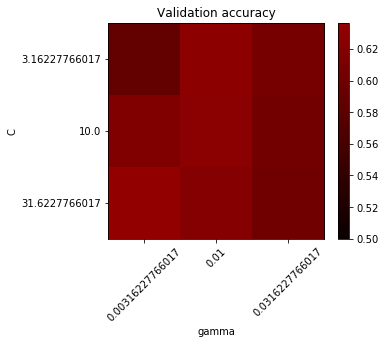

In [66]:
# Visualizing score per combination.

scores = clf.cv_results_['mean_test_score'].reshape((len(C_range), len(gamma_range)))
print("Mean scores:", '\n', scores)

stddev = clf.cv_results_['std_test_score'].reshape((len(C_range), len(gamma_range)))
print("Standard deviation:", '\n', stddev)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.5, midpoint=0.83))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [72]:
# Selecting the best parameters and estimating success scores on test data.

best_C     = 10 ** (2 / 2)
best_gamma = 10 ** (-4 / 2)

pipeline = make_pipeline(StandardScaler(), SVC(C=best_C, gamma=best_gamma, cache_size=2000, class_weight='balanced'))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f1: 0.605559504927
Train data: 38297 Test data: 8395


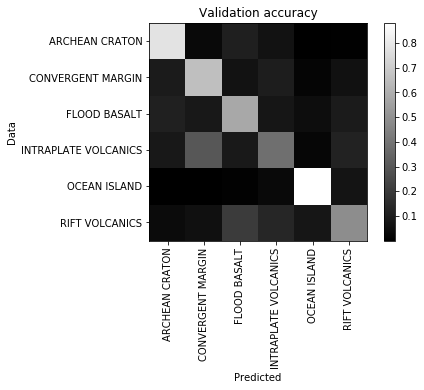

In [73]:
# Viewing validation results.

f1 = f1_score(y_test, y_pred, average='weighted')

conf = confusion_matrix(y_test, y_pred)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]  # Normalizes
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.gray)
plt.xlabel('Predicted')
plt.ylabel('Data')
plt.colorbar()
labels = ['ARCHEAN CRATON',
          'CONVERGENT MARGIN',
          'FLOOD BASALT',
          'INTRAPLATE VOLCANICS',
          'OCEAN ISLAND',
          'RIFT VOLCANICS']
range_ = np.arange(len(labels))
plt.xticks(range_, labels, rotation=90)
plt.yticks(range_, labels)
plt.title('Validation accuracy')

print('f1:', str(f1))
print('Train data:', y_train.shape[0], 'Test data:', y_test.shape[0])
plt.show()

### 2) Nearest Neighbors

In [ ]:
# Launching the grid search.

# neighbors_range = np.arange(10, 101, 10)
neighbors_range = np.arange(1, 11)
# neighbors_range = 10.0 ** (np.arange(0, 5))
weights = ['uniform', 'distance']
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range, kneighborsclassifier__weights=weights)
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(class_weight='balanced'))
# print(pipeline.get_params().keys())
f1_scorer = make_scorer(f1_score, average='weighted')

start = datetime.datetime.now()
print("Start time :", start)

# Regular grid search.
# grid = GridSearchCV(pipeline, param_grid, cv=2, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Grid search using file splitting.
cv = file_split_gen(filenames_train, n_out=8, n_splits=2, seed=43)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Data fitting.
clf = grid.fit(X_train, y_train)  # Will take quite some time. View the progress on the console.

end = datetime.datetime.now()
print("Start time:", end)
print("Time elapsed:", end - start, '\n')

print("Best parameters set found on development set:")
print(clf.cv_results_['params'][clf.best_index_])
print("Score: %0.03f" % clf.best_score_)

In [ ]:
# Visualizing score per combination.

scores = clf.cv_results_['mean_test_score'].reshape((len(neighbors_range), len(weights)))
print("Mean scores:", '\n', scores)

stddev = clf.cv_results_['std_test_score'].reshape((len(neighbors_range), len(weights)))
print("Standard deviation:", '\n', stddev)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.4, midpoint=0.83))
plt.xlabel('Weights')
plt.ylabel('Quantity of neighbors')
plt.colorbar()
plt.xticks(np.arange(len(weights)), weights, rotation=45)
plt.yticks(np.arange(len(neighbors_range)), neighbors_range)
plt.title('Validation accuracy')
plt.show()

In [ ]:
# Selecting the best parameters and estimating success scores on test data.

best_n      = 8
best_weight = 'distance'

pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=best_n, weights=best_weight, class_weight='balanced'))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [ ]:
# Viewing validation results.

f1 = f1_score(y_test, y_pred, average='weighted')

conf = confusion_matrix(y_test, y_pred)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]  # Normalizes
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.gray)
plt.xlabel('Predicted')
plt.ylabel('Data')
plt.colorbar()
labels = ['ARCHEAN CRATON',
          'CONVERGENT MARGIN',
          'FLOOD BASALT',
          'INTRAPLATE VOLCANICS',
          'OCEAN ISLAND',
          'RIFT VOLCANICS']
range_ = np.arange(len(labels))
plt.xticks(range_, labels, rotation=90)
plt.yticks(range_, labels)
plt.title('Validation accuracy')

print('f1:', str(f1))
print('Train data:', y_train.shape[0], 'Test data:', y_test.shape[0])
plt.show()

### 3) Random forest

In [133]:
# Launching the grid search.

range_1 = np.arange(1, 11)
range_2 = np.arange(0.4, 0.9, 0.2)
# estimators_range = np.arange(10, 101, 20)
param_grid = dict(extratreesclassifier__min_samples_leaf=range_1,
                 extratreesclassifier__max_features=range_2)
pipeline = make_pipeline(StandardScaler(), ExtraTreesClassifier(class_weight='balanced', max_depth=40, n_estimators=90))
# print(pipeline.get_params().keys())
f1_scorer = make_scorer(f1_score, average='weighted')

start = datetime.datetime.now()
print("Start time :", start)

# Regular grid search.
grid = GridSearchCV(pipeline, param_grid, cv=2, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Grid search using file splitting.
# cv = file_split_gen(filenames_train, n_out=8, n_splits=3, seed=43)
# grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1, verbose=2)

# Data fitting.
clf = grid.fit(X_train, y_train)  # Will take quite some time. View the progress on the console.

end = datetime.datetime.now()
print("Start time:", end)
print("Time elapsed:", end - start, '\n')

print("Best parameters set found on development set:")
print(clf.cv_results_['params'][clf.best_index_])
print("Score: %0.03f" % clf.best_score_)

Start time : 2017-07-13 12:39:29.252895
Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   37.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   37.2s finished


Start time: 2017-07-13 12:40:16.609895
Time elapsed: 0:00:47.357000 

Best parameters set found on development set:
{'extratreesclassifier__max_features': 0.80000000000000016, 'extratreesclassifier__min_samples_leaf': 1}
Score: 0.775


Mean scores: 
 [[ 0.76866376  0.7638302   0.74655872  0.73089114  0.71184444  0.70381768
   0.69163312  0.68332462  0.67605511  0.66881533]
 [ 0.77118911  0.76908854  0.753837    0.73616043  0.72130709  0.71355767
   0.70188399  0.69482657  0.68606527  0.68114959]
 [ 0.77464623  0.76927785  0.75614588  0.74082335  0.72754965  0.71644619
   0.70708494  0.69826007  0.69321976  0.68535883]]
Standard deviation: 
 [[ 0.00102574  0.00071371  0.00265762  0.00165539  0.00211103  0.00119512
   0.00049776  0.00298603  0.00145603  0.00033557]
 [ 0.00066912  0.00249081  0.00382232  0.00090266  0.00143646  0.00110488
   0.0002388   0.00018062  0.00118936  0.00105666]
 [ 0.00019918  0.00185566  0.00054436  0.00026847  0.00228222  0.00026572
   0.00280883  0.00023524  0.00210777  0.00038145]]


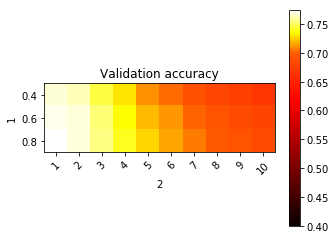

In [134]:
# Visualizing score per combination.

scores = clf.cv_results_['mean_test_score'].reshape((len(range_2), len(range_1)))
print("Mean scores:", '\n', scores)

stddev = clf.cv_results_['std_test_score'].reshape((len(range_2), len(range_1)))
print("Standard deviation:", '\n', stddev)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.4, midpoint=0.7))
plt.xlabel('2')
plt.ylabel('1')
plt.colorbar()
plt.xticks(np.arange(len(range_1)), range_1, rotation=45)
plt.yticks(np.arange(len(range_2)), range_2)
plt.title('Validation accuracy')
plt.show()

In [142]:
# Selecting the best parameters and estimating success scores on test data.

best_depth      = 50
best_estimators = 100
best_leaf       = 3
best_features   = 0.8

clf = ExtraTreesClassifier(max_depth=best_depth, 
                           n_estimators=best_estimators, 
                           min_samples_leaf=best_leaf, 
                           max_features=best_features,  
                           class_weight='balanced')
pipeline = make_pipeline(StandardScaler(), clf)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f1: 0.795691649009
Train data: 21011 Test data: 25681


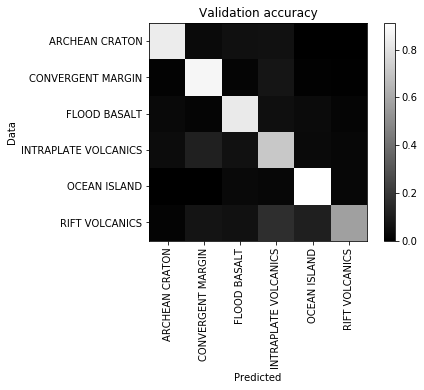

In [143]:
# Viewing validation results.

f1 = f1_score(y_test, y_pred, average='weighted')

conf = confusion_matrix(y_test, y_pred)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]  # Normalizes
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.gray)
plt.xlabel('Predicted')
plt.ylabel('Data')
plt.colorbar()
labels = ['ARCHEAN CRATON',
          'CONVERGENT MARGIN',
          'FLOOD BASALT',
          'INTRAPLATE VOLCANICS',
          'OCEAN ISLAND',
          'RIFT VOLCANICS']
range_ = np.arange(len(labels))
plt.xticks(range_, labels, rotation=90)
plt.yticks(range_, labels)
plt.title('Validation accuracy')

print('f1:', str(f1))
print('Train data:', y_train.shape[0], 'Test data:', y_test.shape[0])
plt.show()

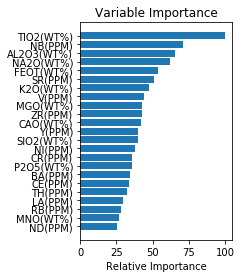

In [137]:
# Importance of each element regarding classification.

feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, filtered_file.iloc[:, 28:-1].axes[1].values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Test using only the major tectonic settings

In [ ]:
temp = filtered_file[filtered_file['TECTONIC SETTING'].isin(['CONVERGENT MARGIN', 'INTRAPLATE VOLCANICS',
                                                             'OCEAN ISLAND', 'CONTINENTAL FLOOD BASALT',
                                                             'RIFT VOLCANICS', 'ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)'])]
temp = temp.reset_index(drop=True)

generator = file_split_gen(temp['FILENAME'], n_out=40, n_splits=3, seed=42)
train_ind, test_ind = next(generator)

X = temp.iloc[:, 28:-1]
y = temp['TECTONIC SETTING']

X_train, X_test = X.iloc[train_ind].reset_index(drop=True), X.iloc[test_ind].reset_index(drop=True)
y_train, y_test = y.iloc[train_ind].reset_index(drop=True), y.iloc[test_ind].reset_index(drop=True)
filenames_train = temp['FILENAME'].iloc[train_ind].reset_index(drop=True)

print(y_train.value_counts()[0])
for setting in y_train.value_counts():
    print(y_train[setting].count(0))

count_ = y_test.value_counts()
print(count_)
print(len(count_), 'settings out of 11.')
print("Test data:", y_test.shape[0], "Out of:", y_test.shape[0] + y_train.shape[0])  # , temp.shape[0])